# Visualization in Embedding Space for the articles

In [1]:
import numpy as np
np.random.seed(0)

In [2]:
import pickle
import gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

import json
from collections import defaultdict, Counter
from nltk.corpus import stopwords
stopwords_set = stopwords.words("english")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


### Data Prep

In [4]:
articles = "/content/drive/MyDrive/Career Guide Public Content/article.json"

art = []
with open(articles, "r", encoding="utf-8") as f:
    for line in f:
        art.append(json.loads(line))

rev_train = pd.DataFrame(pd.DataFrame(art))
rev_train['content_len'] = rev_train['content'].apply(lambda x: len(x.split()))

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['am','really','they','go','get','we','me','would','like','great','should','must']) 

In [6]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [11]:
def strip_newline(series):
    """
    stripping out new line
    """                    
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    """
    Converting sentence to words
    """                
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    """
    Used for removing stopwords
    """            
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    """
    Find the bigrams in the content of the article
    """        
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

name_regex = "[^]]+"
url_regex = "http[s]?://[^)]+"
markup_regex = '\[({0})]\(\s*({1})\s*\)'.format(name_regex, url_regex)

def related_articles(corpus):
    """
    Find the articles related to each content title and content
    """    
    related_art = defaultdict(dict)
    for content, title in zip(corpus["content"], corpus["contentTitle"]):
        content = content.split("\n")
        for i, cont in enumerate(content):
            cont = cont.replace("*","")
            try:            
                for match in re.findall(markup_regex, cont):
                    related_art[title][match[0]] = match[1]
            except :
                print(cont)
    return related_art

# def remove_hyperlinks(corpus, col):
#     """
#     Remove hyperlinks from the content
#     """  
#     for i, content in enumerate(corpus[col]):
#         content = content.split("\n")
#         for j, cont in enumerate(content):
#             content[j] = content[j].replace("*","")
#             if cont!='':
#                 if "https" in cont or "http" in cont:
#                     content[j] = ""
#         corpus.iloc[i]["content"] = " ".join(content)
#     return corpus
def remove_hyperlinks(corpus):
    """
    Remove hypoerlinks from the content
    """  
    fixed_content = [] 
    for i, content in enumerate(corpus["content"]):
        content = content.split("\n")
        #print(content)
        for i, cont in enumerate(content): 
            if cont!='':
                if "https" in cont:
                    content[i] = ""
        #corpus.iloc[i]["content"] = " ".join(content)
        fix_ = " ".join(content)
        #print(fix_)
        fixed_content.append(fix_)
    
    corpus["content"] = fixed_content
    return corpus
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    rltd_articles = {}
    rltd_articles = related_articles(rev_train)
    #df = remove_hyperlinks(df, 'content')
    df = remove_hyperlinks(df)
    df['content'] = strip_newline(df.content)
    words = list(sent_to_words(df.content))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram



In [12]:
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)


In [13]:
for i, content in enumerate(rev_train['content']):
    content_ = striphtml(content) 
    rev_train['content'][i] = content_

In [14]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(rev_train)

### Gensim Doc2Vec 

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Make bigram_train4 to document-wise format

In [16]:
document_list = []
for i, tokenized_sentence in enumerate(bigram_train4):
    complete_sentence = " ".join(tokenized_sentence)
    document_list.append(complete_sentence)

In [17]:
document_list[0]

'quick navigation importance work schedules opting flextime schedule tips help managers schedule employees creating organized schedule works everyone challenge even experienced managers career track becoming supervisor guide help understand_importance developing work schedule meet employees company needs importance work schedules management difficult role right path everyone also rewarding help succeed long_term career goals example management time support grow talented well functioning team major impact organization effective manager also means position mentor employees succeed career goals developing good work schedule skill learn time practice even may address unhappy employees understaffed hours adjust schedules properly often means using flexible working hours allow stagger employee shifts give reports better work life_balance opting flextime schedule available team flexible_schedules might good_option option many companies roles require office regular working hours customer suppo

Tag documents using TaggedDocument


In [18]:
tagged_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(document_list)]

Now we create a Doc2Vec model by using the TaggedDocument above

In [19]:
model_d2v = Doc2Vec(vector_size=100,alpha=0.025, min_count=1)
model_d2v.build_vocab(tagged_data)

Train the model

In [20]:
for epoch in range(10):
    model_d2v.train(tagged_data,
                total_examples=model_d2v.corpus_count,
                #epochs=model_d2v.epochs
                epochs=2)

Initialized document embeddings as an np matrix with all value 0. The shape of the document embeddings will be (len(document_list), vector_size)

In [21]:
document_embeddings=np.zeros((len(document_list),100))
for i in range(len(document_embeddings)):
    document_embeddings[i]=model_d2v.docvecs[i]

In [22]:
document_embeddings

array([[ 0.27598751, -0.20046164,  0.22168975, ..., -0.47924775,
        -0.03883314,  0.28927127],
       [-0.54114765, -0.16465837,  0.41930389, ...,  0.14850172,
         0.08955393, -0.33527952],
       [-0.0041163 ,  0.02908084, -0.312038  , ..., -0.52722406,
        -0.30707729,  0.1101211 ],
       ...,
       [ 0.00494248, -0.22712202, -0.55716556, ..., -0.46579266,
         0.08151589, -0.19890837],
       [-0.190632  , -0.14377211, -0.18248963, ..., -0.34603524,
        -0.28982234, -0.25882545],
       [ 0.04696809, -0.0620921 ,  0.23427217, ..., -0.42268386,
        -0.24082778, -0.08906938]])

In [23]:
document_embeddings.shape

(13639, 100)

In [24]:
import sklearn
pairwise_similarities=sklearn.metrics.pairwise.cosine_similarity(document_embeddings)
pairwise_differences=sklearn.metrics.pairwise.euclidean_distances(document_embeddings)
#Doc2Vec.most_similar(0,pairwise_similarities,'Cosine Similarity')
#Doc2Vec.most_similar(0,pairwise_differences,'Euclidean Distance')

In [25]:
pairwise_similarities

array([[ 1.        ,  0.13943194, -0.08145214, ...,  0.18131474,
        -0.01288021,  0.21048106],
       [ 0.13943194,  1.        ,  0.03873049, ...,  0.176567  ,
         0.26097615,  0.24124968],
       [-0.08145214,  0.03873049,  1.        , ...,  0.10703448,
        -0.06718308,  0.2805918 ],
       ...,
       [ 0.18131474,  0.176567  ,  0.10703448, ...,  1.        ,
         0.20096733,  0.04385278],
       [-0.01288021,  0.26097615, -0.06718308, ...,  0.20096733,
         1.        ,  0.54558155],
       [ 0.21048106,  0.24124968,  0.2805918 , ...,  0.04385278,
         0.54558155,  1.        ]])

In [27]:
def find_similar_docs(pairwise_matrix, top_num = 5):
    '''
    This function will generate the top X (default 5) number of doc pairs that have the highest similarty scores in this matrix

    Parameter:
    ---------
    pairwise_matrix: (array tensor) the similarity matrix

    Return:
    ------
    similar_doc_ids: (list) a list of tuples that indicates the most similar pair of documents
    similar_scores: (list) a list of similarity scores for the documents
    '''
    # turn symmetrical values to 0
    pairwise_matrix[np.tril_indices_from(pairwise_matrix, -1)] = 0
    # turn matrix diagonal to 0
    for i in range(len(pairwise_matrix[0])):
        pairwise_matrix[i][i] = 0
    
    index_tuple = np.unravel_index(np.argsort(pairwise_matrix.ravel())[-top_num:], pairwise_matrix.shape)
    similar_doc_ids = []
    for i in range(top_num):
        similar_doc_ids.append((index_tuple[0][i], index_tuple[1][i]))
    
    similar_scores = pairwise_matrix[index_tuple]
    return similar_doc_ids, similar_scores


In [28]:
find_similar_docs(pairwise_similarities)

([(4713, 4747), (5651, 5677), (6414, 7353), (6757, 6758), (7699, 7756)],
 array([0.92785401, 0.92983727, 0.93355334, 0.93718731, 0.94442069]))

Referring to the previous 2 code chunks, if we generate the top 5 pair of documents in terms of their `cosine-similarity` scores, the function generates 5 pair of indecies that indicate the document ids, and it's related scores.

In [29]:
rev_train.iloc[7699]

_id                          {'$oid': '5ff6486791ee1f0047d4353f'}
title                                                         NaN
content         When accountants calculate the financial outlo...
category                                       career-development
urlRoute                                   assets-and-liabilities
contentTitle    Understanding Assets and Liabilities (With Exa...
locale                                                      en_us
content_len                                                  1688
Name: 7699, dtype: object

In [30]:
rev_train.iloc[7756]

_id                          {'$oid': '5ff6494ef28c6c004a2dbe7c'}
title                                                         NaN
content         Knowing how to use equations in accounting can...
category                                       career-development
urlRoute                                  equations-in-accounting
contentTitle    How To Calculate and Use The Basic Accounting ...
locale                                                      en_us
content_len                                                  1277
Name: 7756, dtype: object

### Load Gensim LDA model

In [31]:
# Load model 
lda_train4 = gensim.models.ldamulticore.LdaMulticore.load("/content/drive/MyDrive/Gensim_LDA/models/lda_train4_23.model")
lda_train30 = gensim.models.LdaModel.load("/content/drive/MyDrive/Gensim_LDA/models/lda_train4_30.model")
lda_train40 = gensim.models.LdaModel.load("/content/drive/MyDrive/Gensim_LDA/models/lda_train4_40.model")
lda_train50 = gensim.models.LdaModel.load("/content/drive/MyDrive/Gensim_LDA/models/lda_train4_50.model")


In [27]:
len(lda_train30.id2word)

22885

In [28]:
def matrix_generator(ldamodel, num_topics, num_words):

    phi_matrix = []
    word_matrix = []
    for i in range(num_topics):
        phi_word = ldamodel.print_topics(num_topics=num_topics, num_words=num_words)[i][1]
        splitted_phi_word = phi_word.split("+")
        phi_list = []
        word_list = []
        for phiword in splitted_phi_word:
            phi, word = phiword.split("*")
            phi_list.append(phi)
            word_list.append(word)
        phi_matrix.append(phi_list)
        word_matrix.append(word_list)
    
    return phi_matrix, word_matrix


In [29]:
# shape: (30, len(lda_train30.id2word))
#        (30, 22885)
phi_30, word_30 = matrix_generator(lda_train30, 30, len(lda_train30.id2word))

In [30]:
# shape: (30, len(lda_train40.id2word))
#        (40, 22885)
phi_40, word_40 = matrix_generator(lda_train40, 40, len(lda_train40.id2word))

In [31]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    plt.ion()

Let us now look at the Jaccard Distance metric for similarity between bags of words (i.e, documents)

The bigger the value, the more distinct these topics are.

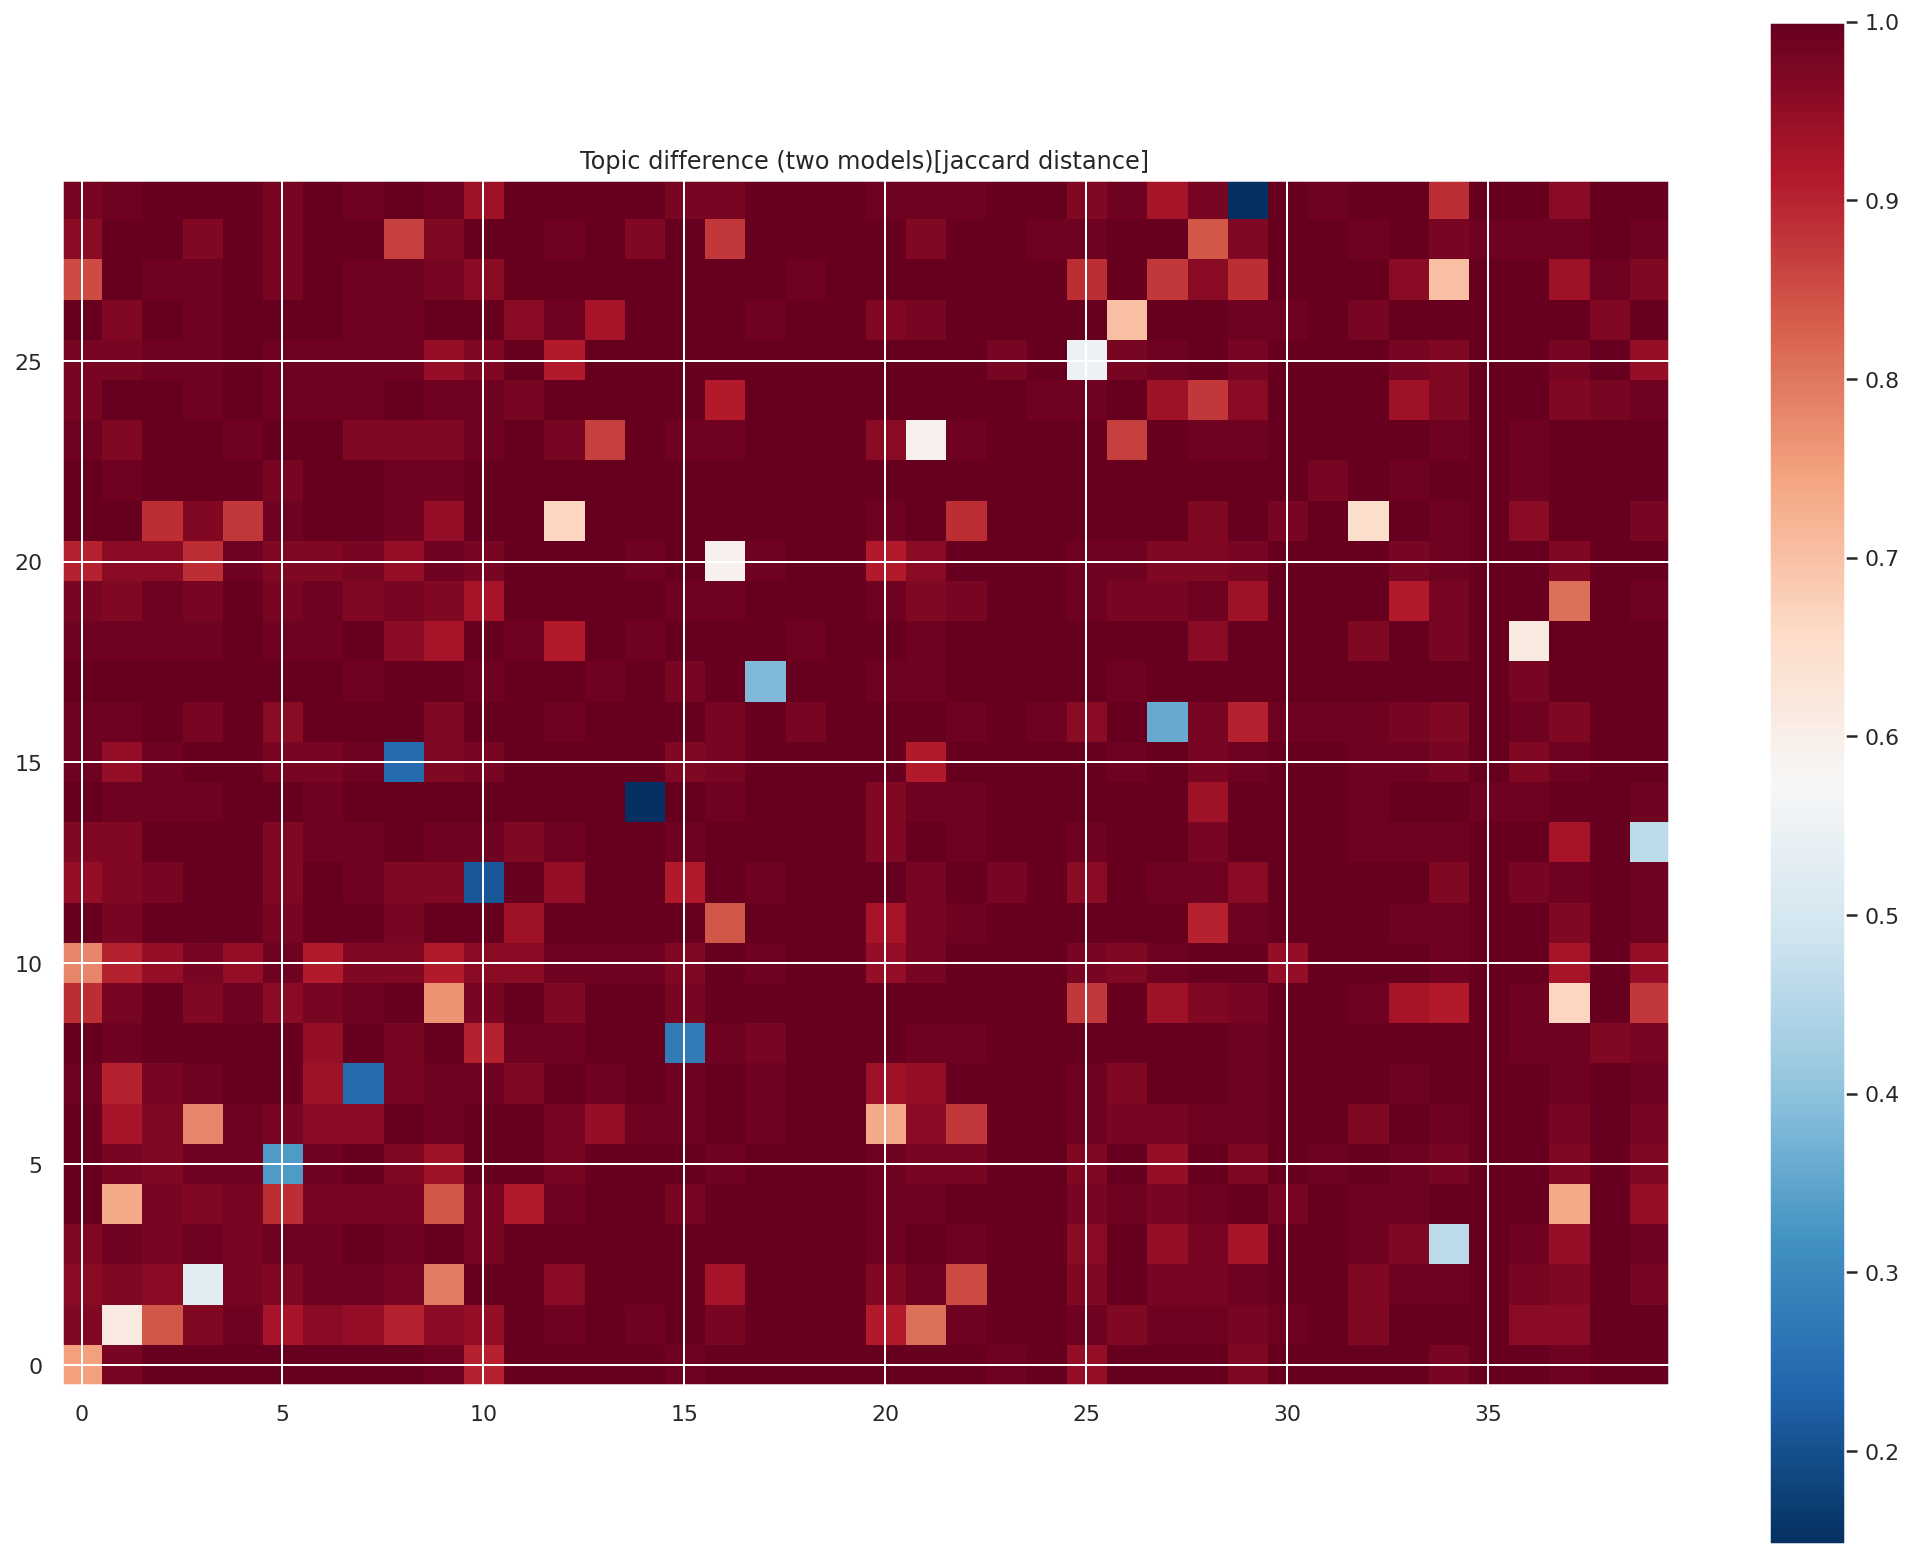

In [45]:
mdiff, annotation = lda_train30.diff(lda_train40, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (two models)[jaccard distance]", annotation=annotation)

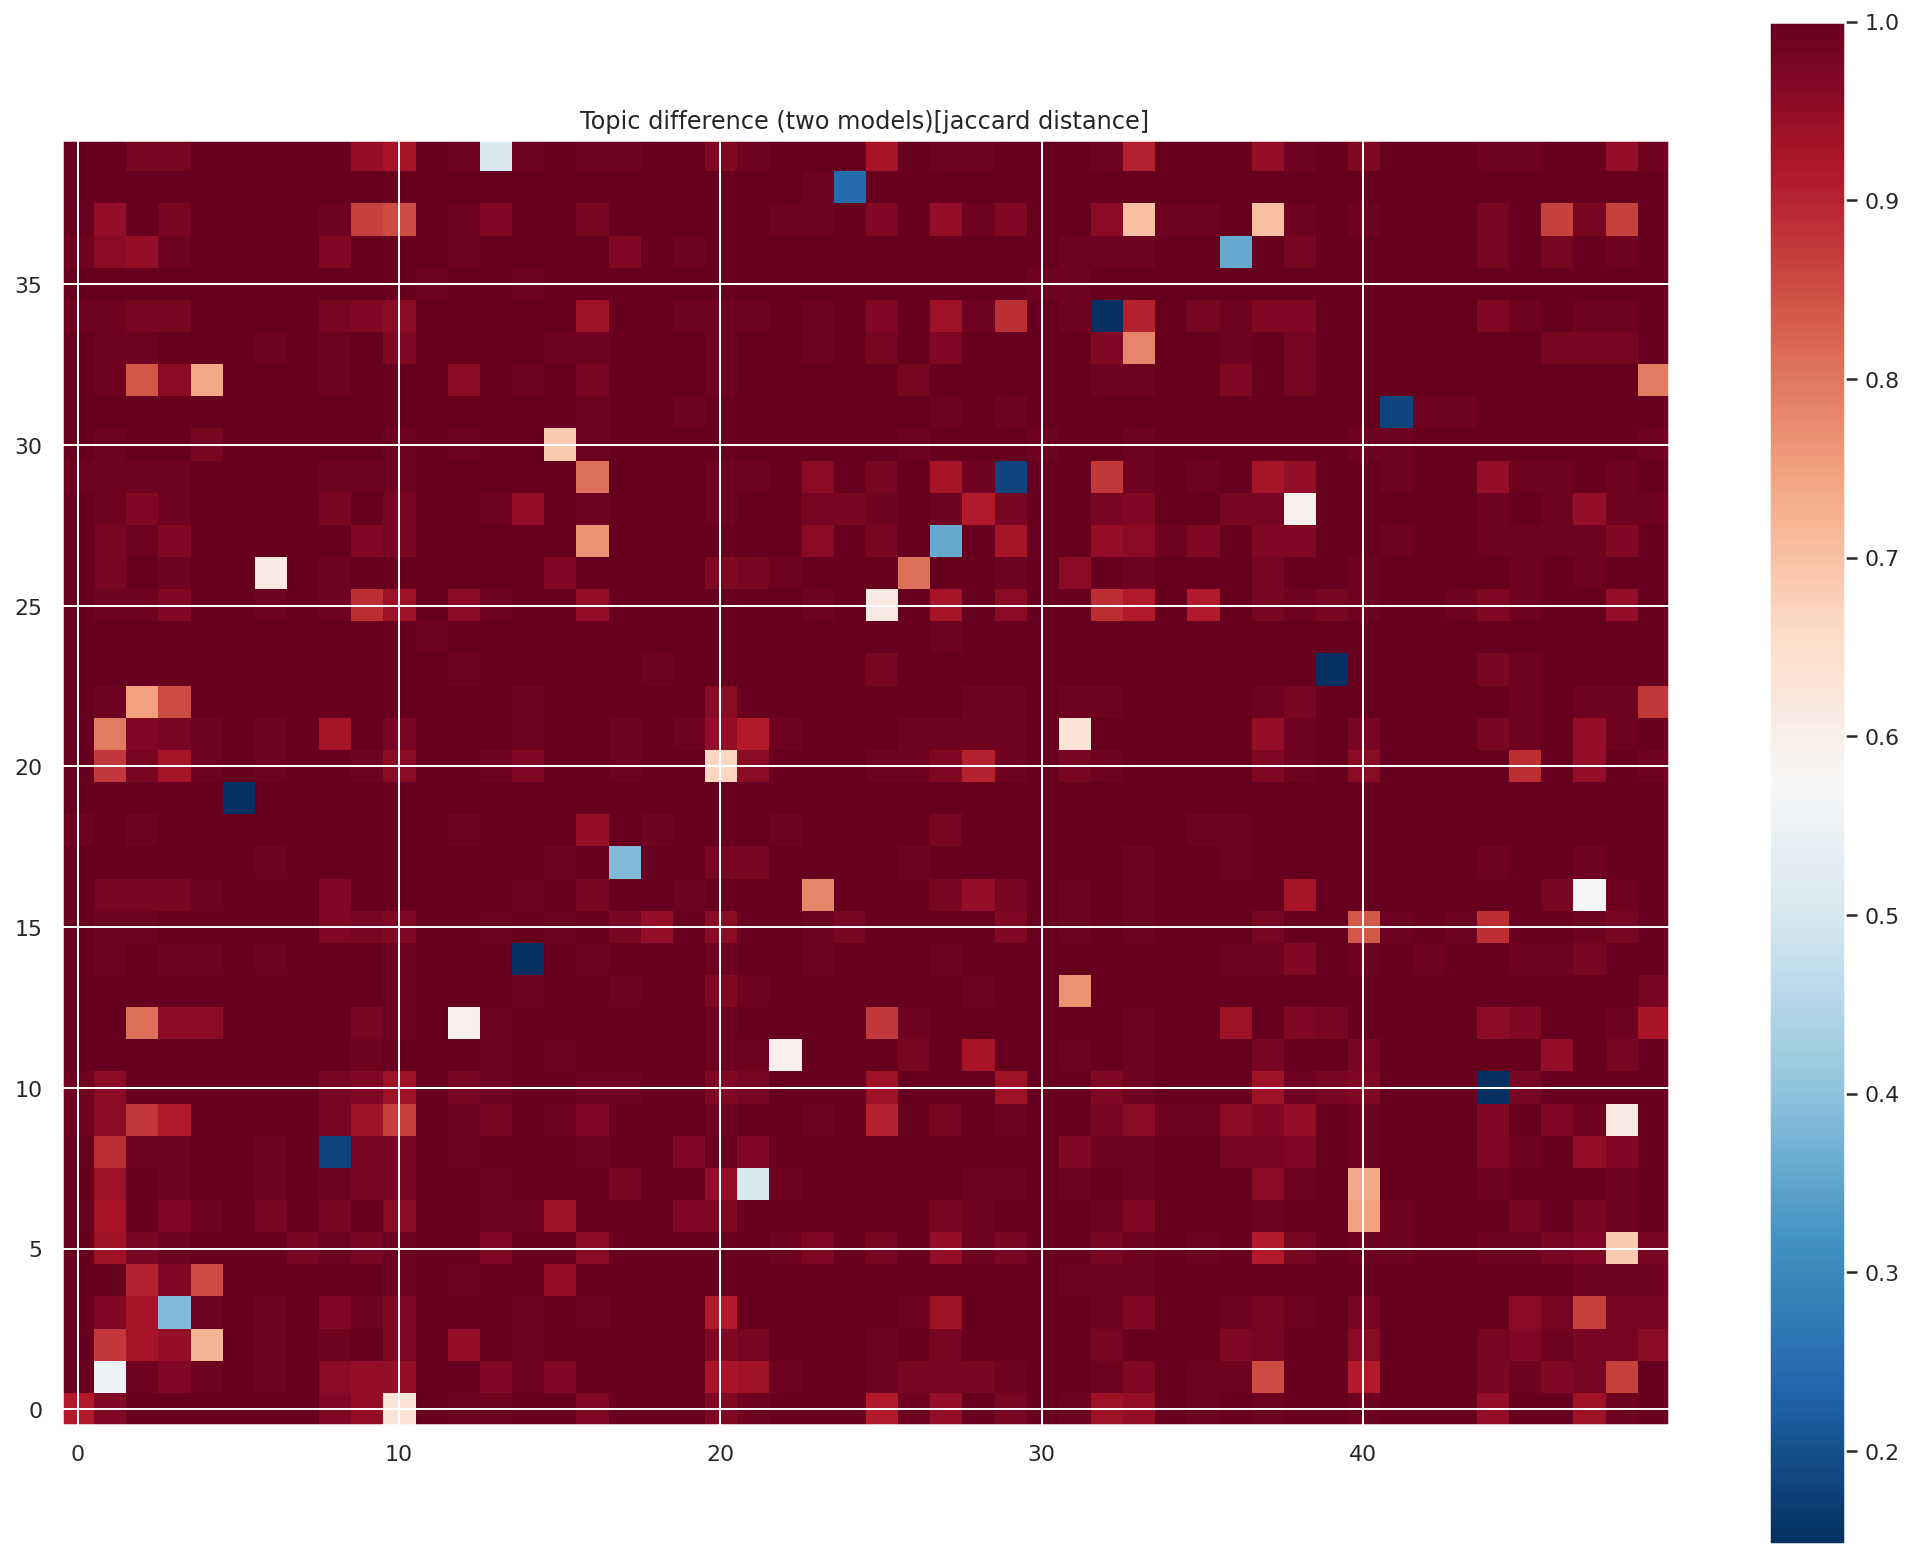

In [46]:
mdiff, annotation = lda_train40.diff(lda_train50, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (two models)[jaccard distance]", annotation=annotation)

In [47]:
from pprint import pprint
pprint(lda_train30.print_topics(num_topics=30))
doc_lda = lda_train30[train_corpus4]

[(0,
  '0.033*"candidates" + 0.029*"internship" + 0.021*"recruiters" + '
  '0.020*"interns" + 0.018*"hiring" + 0.012*"positions" + 0.011*"intern" + '
  '0.011*"internships" + 0.011*"recruitment" + 0.010*"hire"'),
 (1,
  '0.031*"primary_duties" + 0.012*"professionals" + 0.010*"engineering" + '
  '0.010*"clients" + 0.009*"financial" + 0.008*"engineers" + 0.007*"design" + '
  '0.007*"consultant" + 0.006*"managers" + 0.006*"operations"'),
 (2,
  '0.028*"product" + 0.028*"marketing" + 0.023*"customers" + 0.018*"sales" + '
  '0.016*"customer" + 0.016*"products" + 0.011*"brand" + 0.010*"market" + '
  '0.008*"businesses" + 0.007*"consumers"'),
 (3,
  '0.025*"questions" + 0.021*"answer" + 0.019*"question" + '
  '0.013*"interview_questions" + 0.012*"describe" + 0.010*"interview" + '
  '0.010*"interviewer" + 0.009*"tell" + 0.009*"employers" + 0.007*"ask"'),
 (4,
  '0.032*"manager" + 0.025*"managers" + 0.013*"leadership" + 0.013*"teams" + '
  '0.011*"team_members" + 0.011*"communication" + 0.010*"

In [48]:
from pprint import pprint
pprint(lda_train40.print_topics(num_topics=40))
doc_lda = lda_train40[train_corpus4]

[(0,
  '0.018*"event" + 0.016*"social_media" + 0.013*"online" + 0.012*"events" + '
  '0.012*"candidates" + 0.011*"opportunities" + 0.010*"website" + '
  '0.010*"network" + 0.010*"professionals" + 0.008*"search"'),
 (1,
  '0.029*"manager" + 0.027*"primary_duties" + 0.024*"managers" + '
  '0.012*"professionals" + 0.011*"operations" + 0.009*"staff" + 0.008*"duties" '
  '+ 0.008*"roles" + 0.007*"manage" + 0.007*"department"'),
 (2,
  '0.051*"financial" + 0.030*"clients" + 0.027*"accounting" + '
  '0.019*"consultant" + 0.017*"finance" + 0.014*"consultants" + '
  '0.011*"insurance" + 0.011*"client" + 0.007*"banking" + 0.007*"businesses"'),
 (3,
  '0.050*"sales" + 0.046*"customers" + 0.041*"marketing" + 0.036*"customer" + '
  '0.031*"product" + 0.017*"products" + 0.015*"brand" + 0.008*"purchase" + '
  '0.008*"customer_service" + 0.007*"consumers"'),
 (4,
  '0.018*"investment" + 0.016*"investors" + 0.014*"equity" + 0.013*"board" + '
  '0.013*"capital" + 0.011*"partnership" + 0.011*"partner" + 